In [1]:
import sys
path = ".."
if path not in sys.path:
    sys.path.append(path)

In [2]:
from lieposenet.data.seven_scenes import SevenScenes

In [3]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor

In [4]:
x = 5.525370066993806617e-02
x ** 0.5

0.23506105732327945

In [5]:
image_transform = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset = SevenScenes("fire", "../data/7scenes", True, image_transform, mode=0, seed=0, sequences=[4])

In [6]:
data_loader = torch.utils.data.DataLoader(dataset, 32, True, pin_memory=True, num_workers=4)

In [9]:
resnet = models.resnet34(pretrained=True)
resnet_parts = list(resnet.children())
model = nn.Sequential(*resnet_parts[:-1]).cuda()
model.eval();

In [7]:
from lieposenet.data.seven_scenes import SevenScenes
from lieposenet.utils import TensorBoardLogger, load_hparams_from_yaml
from lieposenet import ModelFactory

In [8]:
params = load_hparams_from_yaml("../configs/pose_net.yaml")
# Make model
model = ModelFactory().make_model(params.model, data_saver_path=".")

# Load model
model.load_state_dict(torch.load("../models/fire_pose_net.pth.ckpt")['state_dict'])
model = model.feature_extractor.cuda()
model.eval();

In [9]:
features = np.zeros([0, 512])
positions = np.zeros([0, 4, 4])
for batch in data_loader:
    result = model(batch["image"].cuda())[:, :, 0, 0].cpu().detach().numpy()
    features = np.concatenate([features, result], axis=0)
    positions = np.concatenate([positions, batch["position"]], axis=0)

IndexError: too many indices for tensor of dimension 2

In [10]:
def get_sequence_data(sequence):
    image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])
    dataset = SevenScenes("fire", "../data/7scenes", True, image_transform, mode=0, seed=0, sequences=[sequence])
    data_loader = torch.utils.data.DataLoader(dataset, 32, False, pin_memory=True, num_workers=4)
    features = np.zeros([0, 2048])
    positions = np.zeros([0, 4, 4])
    for batch in data_loader:
        result = model(batch["image"].cuda())[:, :].cpu().detach().numpy()
        features = np.concatenate([features, result], axis=0)
        positions = np.concatenate([positions, batch["position"]], axis=0)
    return features, positions

In [11]:
positions.shape

(0, 4, 4)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

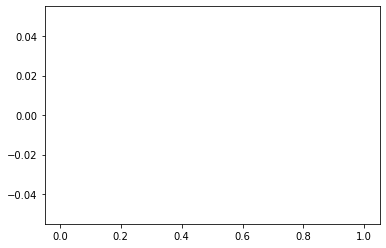

In [12]:
plt.hist(positions[:, 0, 3])

In [13]:
x = np.ones(10)

In [14]:
def invert_positions(positions):
    result = np.zeros_like(positions)
    result[:, :3, :3] = np.transpose(positions[:, :3, :3], (0, 2, 1))
    result[:, :3, 3] = -np.einsum('ijk, ik->ij', result[:, :3, :3], positions[:, :3, 3])
    result[:, 3, 3] = 1
    return result

In [15]:
y = features[:, 0]
inv_posistions = invert_positions(positions)
x = np.concatenate([inv_posistions[:, :3, :].reshape(-1, 12),
                    inv_posistions[:, :3, :].reshape(-1, 12) * y[:, None]], axis=1)

In [16]:
def get_linear_regression(features, positions):
    inv_posistions = invert_positions(positions)
    y = inv_posistions[:, :3, :].reshape(-1, 12)[:, 11]
    x = np.concatenate([inv_posistions[:, :3, :].reshape(-1, 12)[:, :11],
                        inv_posistions[:, :3, :].reshape(-1, 12)[:, :12] * features[:, 0][:, None]], axis=1)
    reg = LinearRegression().fit(x, y)
    print(reg.score(x, y))
    return reg

def test_regression(reg, features, positions):
    inv_posistions = invert_positions(positions)
    y = inv_posistions[:, :3, :].reshape(-1, 12)[:, 11]
    x = np.concatenate([inv_posistions[:, :3, :].reshape(-1, 12)[:, :11],
                        inv_posistions[:, :3, :].reshape(-1, 12)[:, :12] * features[:, 0][:, None]], axis=1)
    return reg.score(x, y)

In [17]:
reg = LinearRegression().fit(x, y)
print(reg.score(x, y))
print(np.round(reg.coef_, 2))

ValueError: Found array with 0 sample(s) (shape=(0, 24)) while a minimum of 1 is required.

In [18]:
reg = LinearRegression().fit(x, y)
reg.score(x, y)
print(np.round(reg.coef_, 2))

ValueError: Found array with 0 sample(s) (shape=(0, 24)) while a minimum of 1 is required.

In [76]:
reg = LinearRegression().fit(x, y)
reg.score(x, y)
print(np.round(reg.coef_, 2))

[-0.83 -0.07 -0.04 -0.    0.02 -0.34 -0.68 -0.03 -0.   -0.54  0.51 -0.02
  1.28  0.1   0.03  0.   -0.03  0.57  1.01  0.04 -0.02  0.83 -0.81  0.03]


In [77]:
reg = LinearRegression().fit(x, y)
reg.score(x, y)
print(np.round(reg.coef_, 2))

[-0.83 -0.07 -0.04 -0.    0.02 -0.34 -0.68 -0.03 -0.   -0.54  0.51 -0.02
  1.28  0.1   0.03  0.   -0.03  0.57  1.01  0.04 -0.02  0.83 -0.81  0.03]


In [19]:
features1, positions1 = get_sequence_data(1)

In [20]:
features2, positions2 = get_sequence_data(2)

In [21]:
features3, positions3 = get_sequence_data(3)

In [22]:
features4, positions4 = get_sequence_data(4)

In [23]:
reg1 = get_linear_regression(features1, positions1)
print(np.round(reg1.coef_, 2))

0.9949956609426406
[ 7.75 -0.48  4.12 -0.13 -1.75 -0.51  1.79 -1.11  4.14 -2.29 -9.3  -1.9
  0.15 -0.9   0.04  0.37 -0.58 -0.47  0.24 -0.95  0.15  2.3   0.22]


In [24]:
test_regression(reg1, features2, positions2)

-1.1405788062163218

In [25]:
reg2 = get_linear_regression(features2, positions2)
print(np.round(reg2.coef_, 2))

0.9973069140834476
[-4.32 -1.29  8.89 -0.06 -3.34  4.11 -4.16 -0.52  8.63 -0.6   0.77  2.02
  0.51 -3.45  0.04  1.25 -1.28  1.99  0.22 -3.4   0.64 -0.29  0.46]


In [26]:
from sklearn.linear_model import BayesianRidge, Lasso,ARDRegression, Ridge, ElasticNet, RidgeCV


In [55]:
def get_linear_regression_angles(features, positions, global_point=np.array([0, 2, 1.5, 1])):
    inv_posistions = invert_positions(positions)
    transformed_point = np.einsum('ijk, k->ij', inv_posistions, global_point)
#     mask = transformed_point[:, 2] > 0.5
#     y = (transformed_point[:, 0] / transformed_point[:, 2])[:]
    y = np.arctan2(transformed_point[:, 0], transformed_point[:, 2])
    print(len(y))
    if len(y) < 0.9 * len(features):
        return None, None
    x = features[:, :]
    x = np.concatenate([x, x ** 2], axis=1)
    regx = BayesianRidge().fit(x, y)
    print(regx.score(x, y))
    y = np.arctan2(transformed_point[:, 1], transformed_point[:, 2])
    regy = BayesianRidge().fit(x, y)
    print(regy.score(x, y))
    return regx, regy

In [56]:
f = np.concatenate([features1, features2], axis=0)
p = np.concatenate([positions1, positions2], axis=0)
regx, regy = get_linear_regression_angles(f, p)

2000
0.9996915104709296
0.9994221517148649


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

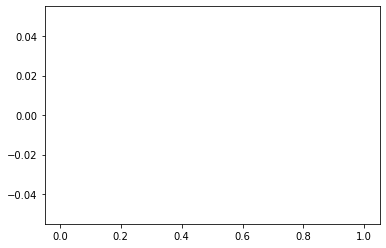

In [29]:
plt.hist(y)

In [63]:
def norm_angles(angles):
    return (angles + np.pi) % (2 * np.pi) - np.pi

def rmse(x):
    return np.sqrt(np.mean(x ** 2))

In [64]:
def test_regression_angles(regx, regy, features, positions, global_point=np.array([0, -1, 1.5, 1])):
    n = len(features)
    inv_posistions = invert_positions(positions)
    transformed_point = np.einsum('ijk, k->ij', inv_posistions, global_point)
#     mask = transformed_point[:, 2] > 0.2
    true_x = np.arctan2(transformed_point[:, 0], transformed_point[:, 2])[:]
    true_y = np.arctan2(transformed_point[:, 1], transformed_point[:, 2])[:]
    features = features[:, :]
    features = np.concatenate([features, features ** 2], axis=1)
    pred_x = np.zeros(n)
    pred_x[:] = regx.predict(features)
#     pred_x[mask] = true_x
    pred_y = np.zeros(n)
    pred_y[:] = regy.predict(features)
#     pred_y[mask] = true_y
    print(len(true_x))
    print("score x ", regx.score(features, true_x))
#     print("error x ", np.mean(np.abs(true_x - pred_x[:])) * 180 / np.pi)
    print("error x ", rmse(true_x - pred_x) * 180 / np.pi)
    print("score y ", regy.score(features, true_y))
    print("error x ", rmse(true_y - pred_y) * 180 / np.pi)
    return pred_x, pred_y, None

In [65]:
test_regression_angles(regx, regy, features4, positions4);

1000
score x  0.5365197506471213
error x  35.89850657342189
score y  0.03727707979362349
error x  16.004789789285365


In [91]:
global_points = np.random.rand(100, 4)
global_points[:, 3] = 1
global_points[:, 0] = 2 * global_points[:, 0] - 0.5
global_points[:, 1] = 2 * global_points[:, 1] - 0.5
global_points[:, 2] = 2 * global_points[:, 2] - 0.5

In [92]:
n = 5
x, y, z =  np.meshgrid(np.linspace(-1.5, 2, n), np.linspace(-2, 0.5, n), np.linspace(-0.5, 2, n))
global_points = np.ones((n ** 3, 4))
global_points[:, 0] = x.flatten()
global_points[:, 1] = y.flatten()
global_points[:, 2] = z.flatten()

In [145]:
global_points = np.array([
    [1, 0, 1.5, 1],
    [1, 1, 1.5, 1],
    [0, 1, 1.5, 1],
    [0, 1, 1, 1],
    [1, 0.5, 1.5, 1],
    [0.5, 0.5, 1.5, 1],
    [-1, 0.5, 1.5, 1],
    [0.5, -0.5, 1.5, 1],
    [0.5, 0.5, 1, 1],
    [0.5, 0.5, 2, 1],
    [2, 1, 1.5, 1],
    [1, 2, 1.5, 1],
])
global_points1 = []
regs = []
f = np.concatenate([features1, features2], axis=0)
p = np.concatenate([positions1, positions2], axis=0)
for point in global_points:
    reg = get_linear_regression_angles(f, p, point)
    if reg[0] is not None:
        regs.append(reg)
        global_points1.append(point)

1623
1884
0.9944334198213858
0.9919540179426569
2000
0.9943961283583784
0.996405513057616
1940
0.9932608132579596
0.9954748820141217
1809
0.9948699507387022
0.9924385041103281
1935
0.9953633598393452
0.9936136903250139
1904
0.9966104933650779
0.9945432762014439
1623
1669
1972
0.9961043194406641
0.9954922322012465
1470
2000
0.9932344204785835
0.9960498408502529


In [146]:
# f = np.concatenate([features3, features4], axis=0)
# p = np.concatenate([positions3, positions4], axis=0)
f = features3
p = positions3
result = []
for point, reg in zip(global_points1, regs):
    result.append(test_regression_angles(reg[0], reg[1], f, p, point))

965
score x  0.6052659763407404
error x  12.919224991137654
score y  0.45818463212338334
error y  24.578755136929963
1000
score x  0.620508657334307
error x  10.755624360555663
score y  0.7957440758223506
error y  7.737438439371494
1000
score x  0.5061820451790178
error x  23.208821627160788
score y  0.7356861267679566
error y  14.713628410277757
928
score x  0.4683330501987071
error x  15.254652122547004
score y  0.28580633382955534
error y  19.408796541978166
973
score x  0.6143710541540772
error x  12.49689071949011
score y  0.6118942317901597
error y  13.186600330040662
902
score x  0.5846010579649225
error x  11.402269987618808
score y  0.303215832816932
error y  22.69610771697707
1000
score x  0.7363166163207059
error x  11.85734715772416
score y  0.7469706231881497
error y  9.933241536181916
1000
score x  0.639358126166414
error x  11.078453583203736
score y  0.7440898285820177
error y  20.24596021143818


In [147]:
import cv2

In [148]:
final_mask = True
for m in result:
    final_mask = final_mask & m[2]
print(np.count_nonzero(final_mask))

830


In [149]:
camera_matrix = np.eye(3)
dist_coef = np.zeros(4)
predicted_trajectory = []
truth_trajectory = p[final_mask, :3, 3]
global_points1 = np.array(global_points1)
for i in range(len(final_mask)):
    if final_mask[i]:
        object_points = global_points1[:, :3].astype(np.float32)
        image_points = []
        for m in result:
            image_points.append(np.array([m[0][i], m[1][i]]))
        image_points = np.array(image_points).astype(np.float32)
        found, rvec, tvec = cv2.solvePnP(object_points[:], image_points[:], camera_matrix, 
                                         dist_coef, flags=cv2.SOLVEPNP_DLS)
        rotM = cv2.Rodrigues(rvec)[0]
        cameraPosition = -np.matrix(rotM).T * np.matrix(tvec)
        cameraPosition = np.array(cameraPosition)[:, 0]
        if np.linalg.norm(cameraPosition) > 3:
            cameraPosition = np.zeros(3)
        predicted_trajectory.append(cameraPosition)
predicted_trajectory = np.array(predicted_trajectory)

In [150]:
truth_trajectory

array([[-0.02662783, -0.40136248,  0.23761126],
       [-0.02639442, -0.40112936,  0.23811397],
       [-0.02547413, -0.40188462,  0.23846774],
       ...,
       [-0.99994254, -0.22821708,  1.00650358],
       [-1.00308919, -0.22899938,  1.00508368],
       [-1.00561941, -0.22976319,  1.00297594]])

In [151]:
predicted_trajectory

array([[-0.75280544, -0.27616141,  0.385516  ],
       [-0.75369979, -0.22637599,  0.35707054],
       [-0.62540621, -0.28665228,  0.19701777],
       ...,
       [-0.66676308, -0.64401909,  0.05588785],
       [-0.72746973, -0.47908938,  0.11822048],
       [-0.66732873, -0.42337003,  0.03453028]])

In [152]:
position_errors = np.linalg.norm(truth_trajectory - predicted_trajectory, axis=1)
print("Mean position error: {}".format(np.mean(position_errors)))
print("Median position error: {}".format(np.median(position_errors)))

Mean position error: 0.8161122583475877
Median position error: 0.7435042919087618


In [153]:
def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
                         y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
                         z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
                         mode="lines",
                         name="errors")
        ]
    )
    fig.show()

In [154]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [155]:
show_trajectories(truth_trajectory, predicted_trajectory)

In [156]:
data = np.loadtxt("/home/mikhail/research/geomapnet/data/7Scenes/fire/dso_poses/seq-03.txt")
odometry_indexes = data[:, 0].astype(np.int)
odometry_positions = np.zeros((data.shape[0], 4, 4))
odometry_positions[:, :3, :] = data[:, 1:].reshape(-1, 3, 4)
odometry_positions[:, 3, 3] = 1.

In [157]:
truth_trajectory = positions3[:, :3, 3]

In [158]:
show_trajectories(truth_trajectory[odometry_indexes], odometry_positions[:, :3, 3])

In [159]:
from minisam import *

In [160]:
graph = FactorGraph()
initials = Variables()
global_points1 = np.array(global_points1)

for i, point in enumerate(global_points1):
    loss = DiagonalLoss.Sigmas(np.array([0.001, 0.001, 0.001]))
    graph.add(PriorFactor(key('g', i), point[:3, None], loss))
    initials.add(key('g', i), point[:3, None])
    

for i in range(len(final_mask)):
    if final_mask[i]:
        image_points = []
        for m in result:
            image_points.append(np.array([m[0][i], m[1][i]]))
        image_points = np.array(image_points).astype(np.float32)[:1]
        loss = DiagonalLoss.Scales(np.array([0.1, 0.1]) * 12)
        for j in range(len(image_points)):
            graph.add(ReprojectionPoseFactor(key('x', i), key('g', j), CalibK(1, 1, 0, 0), image_points[j], loss))
    

linear_sigma = 0.02
angular_sigma = 0.02
odometry_loss = DiagonalLoss.Sigmas(np.array([linear_sigma, linear_sigma, linear_sigma, 
                                              angular_sigma, angular_sigma, angular_sigma]))
for i in range(len(odometry_positions) - 1):
    odometry_delta = odometry_positions[i + 1] @ np.linalg.inv(odometry_positions[i])
    u, d, v = np.linalg.svd(odometry_delta[:3, :3])
    odometry_delta[:3, :3] = u @ v
    graph.add(BetweenFactor(key('x', int(odometry_indexes[i])), key('x', int(odometry_indexes[i + 1])), 
                            SE3(odometry_delta), odometry_loss))

k = 0
odom = odometry_positions[-1]
u, d, v = np.linalg.svd(odom[:3, :3])
odom[:3, :3] = u @ v
for i in range(len(final_mask)):
    if odometry_indexes[k] == i:
        odom = odometry_positions[k]
        u, d, v = np.linalg.svd(odom[:3, :3])
        odom[:3, :3] = u @ v
        
        k += 1
    initials.add(key('x', i), SE3(odom))
    graph.add(PriorFactor(key('x', i), SE3(odom), ScaleLoss.Sigma(1000)))

In [161]:
opt_param = LevenbergMarquardtOptimizerParams()
opt_param.verbosity_level = NonlinearOptimizerVerbosityLevel.SUBITERATION
optimizer = LevenbergMarquardtOptimizer(opt_param)

results = Variables()
status = optimizer.optimize(graph, initials, results)
if status != NonlinearOptimizationStatus.SUCCESS:
    print("optimization error: ", status)

In [162]:
optimized_trajectory = [results.at(key("x", i)).translation() for i in range(1000)]
optimized_trajectory = np.array(optimized_trajectory)
optimized_trajectory

array([[-0.31863474, -0.08186809,  0.39623368],
       [-0.31606287, -0.08445845,  0.39989777],
       [-0.3091134 , -0.08576537,  0.3998659 ],
       ...,
       [-0.53291427,  0.12038209,  0.58290734],
       [-0.53476431,  0.11826405,  0.58211711],
       [-0.53617599,  0.1178543 ,  0.58152019]])

In [163]:
show_trajectories(truth_trajectory, optimized_trajectory)

In [142]:
graph.add(PriorFactor(key('x', i), SE3(SO3(0, 0, 0, 1), np.array([0, 0, 0])), ScaleLoss.Sigma(0)))

In [143]:
position_errors = np.linalg.norm(truth_trajectory[:1000] - optimized_trajectory, axis=1)
print("Mean position error: {}".format(np.mean(position_errors)))
print("Median position error: {}".format(np.median(position_errors)))

Mean position error: 0.6247161420589543
Median position error: 0.3975909491881643


In [144]:
graph = FactorGraph()
graph.add(PriorFactor(key('g', 0), Point2D, ScaleLoss.Sigma(0)))

NameError: name 'Point2D' is not defined

In [ ]:
graph = FactorGraph()
initials = Variables()
for i, (position, sqrt_information) in enumerate(zip(mean_matrix, inverse_sigma_matrix)):
    u, d, v = np.linalg.svd(position[:3, :3])
    position[:3, :3] = u @ v
    priorLoss = GaussianLoss.SqrtInformation(sqrt_information)
    graph.add(PriorFactor(key('x', i), SE3(position), priorLoss))
    initials.add(key('x', i), SE3(position))

linear_sigma = 0.02
angular_sigma = 0.02
odometry_loss = DiagonalLoss.Sigmas(np.array([linear_sigma, linear_sigma, linear_sigma, 
                                              angular_sigma, angular_sigma, angular_sigma]))
for i in range(len(odometry_positions) - 1):
    odometry_delta = odometry_positions[i + 1] @ np.linalg.inv(odometry_positions[i])
    u, d, v = np.linalg.svd(odometry_delta[:3, :3])
    odometry_delta[:3, :3] = u @ v
    graph.add(BetweenFactor(key('x', int(odometry_indexes[i])), key('x', int(odometry_indexes[i + 1])), 
                            SE3(odometry_delta), odometry_loss))

IndexError: _Map_base::at

In [1115]:
from minisam import *

In [928]:
def get_xy_positions(features, positions, axis=0):
    y = positions[:, axis, 3]
    x = features
    return x, y

def get_linear_regression_angles(features, positions, global_point=np.array([0, 0.8, 0.5, 1])):
    inv_posistions = invert_positions(positions)
    transformed_point = np.einsum('ijk, k->ij', inv_posistions, global_point)
    mask = transformed_point[:, 2] > 0.5
    y = (transformed_point[:, 1] / transformed_point[:, 2])[mask]
    print(len(y))
    x = features[mask, :]
    reg = BayesianRidge().fit(x, y)
    print(reg.score(x, y))
    return reg, y

In [654]:
f = np.concatenate([features1, features2], axis=0)
p = np.concatenate([positions1, positions2], axis=0)
x, y = get_xy_positions(f, p)
reg1 = LinearRegression().fit(x, y)
print(reg1.score(x, y))

0.9325723387527436


In [518]:
f = np.concatenate([features3, features3], axis=0)
p = np.concatenate([positions4, positions4], axis=0)
x, y = get_xy_positions(f, p)
reg1.score(x, y)

-0.7479861305353537

In [1076]:
f = np.concatenate([features1, features2], axis=0)
p = np.concatenate([positions1, positions2], axis=0)
# f1 = f ** 2
# f = np.concatenate([f, f1], axis=1)
regx = BayesianRidge().fit(f, p[:, 0, 3])
print(regx.score(f, p[:, 0, 3]))
regy = BayesianRidge().fit(f, p[:, 1, 3])
print(regy.score(f, p[:, 1, 3]))
regz = BayesianRidge().fit(f, p[:, 2, 3])
print(regz.score(f, p[:, 2, 3]))

0.9237292292967303
0.8334768366386264
0.9302964421772411


In [1077]:
f = np.concatenate([features3, features4], axis=0)
p = np.concatenate([positions3, positions4], axis=0)
# f = features4
# p = positions4
# f = np.concatenate([features1, features2], axis=0)
# p = np.concatenate([positions1, positions2], axis=0)
# f1 = f ** 2
# f = np.concatenate([f, f1], axis=1)
x = regx.predict(f)
print(regx.score(f, p[:, 0, 3]))
y = regy.predict(f)
print(regy.score(f, p[:, 1, 3]))
z = regz.predict(f)
print(regz.score(f, p[:, 2, 3]))
predicted_trajectory = np.array([x, y, z]).T
truth_trajectory = p[:, :3, 3]

0.5066196410453708
0.19439622400439038
0.3476259340376276


In [1078]:
print(y)

[-0.55404067 -0.13922028 -0.58045276 ... -0.50405117 -0.11779535
 -0.36303816]


In [1079]:
print( p[:, 1, 3])

[-1.17189431 -0.26196039 -1.13685155 ... -0.36741042 -0.32520294
 -0.37800014]


In [1080]:
position_errors = np.linalg.norm(truth_trajectory - predicted_trajectory, axis=1)
print("Mean position error: {}".format(np.mean(position_errors)))
print("Median position error: {}".format(np.median(position_errors)))

Mean position error: 0.5103402062449253
Median position error: 0.48107374222840216


In [1081]:
show_trajectories(truth_trajectory, predicted_trajectory)

# predicted_trajectory

In [532]:
truth_trajectory

array([[ 0.44931176, -0.7005465 ,  1.15394127],
       [-0.23579977, -0.52102673,  0.44255289],
       [-0.79139328, -0.48299253,  0.66013217],
       ...,
       [-0.86971289,  0.0210365 ,  0.77907294],
       [-0.14412437, -0.2281526 ,  0.37405708],
       [-0.79904211,  0.06535498,  0.52576739]])

In [667]:
def get_xy(features, positions, axis=0):
    y = positions[:, axis, 3]
    x = np.concatenate([features, features * y[:, None]], axis=1)
    return x, y

In [669]:
f = np.concatenate([features1, features2], axis=0)
p = np.concatenate([positions1, positions2], axis=0)

regx = BayesianRidge().fit(*get_xy(f, p, 0))
print(regx.score(*get_xy(f, p, 0)))
regy = BayesianRidge().fit(*get_xy(f, p, 1))
print(regy.score(*get_xy(f, p, 1)))
regz = BayesianRidge().fit(*get_xy(f, p, 2))
print(regz.score(*get_xy(f, p, 2)))

0.9998119712536592
0.9998338928852496
0.9997870023263452


In [671]:
def predict(reg, features, axis=0):
    y0 = reg.predict(np.concatenate([features, features * 0], axis=1))
    y1 = reg.predict(np.concatenate([features, features * 1], axis=1))
    return y0 / (1 - y1 + y0)

In [673]:
f = np.concatenate([features3, features4], axis=0)
p = np.concatenate([positions3, positions4], axis=0)
x = predict(regx, f)
print(regx.score(*get_xy(f, p, 0)))
y = predict(regy, f)
print(regy.score(*get_xy(f, p, 1)))
z = predict(regz, f)
print(regz.score(*get_xy(f, p, 2)))
predicted_trajectory = np.array([x, y, z]).T
truth_trajectory = p[:, :3, 3]

0.9973939299845952
0.9978913108885445
0.9970293579549172


In [674]:
position_errors = np.linalg.norm(truth_trajectory - predicted_trajectory, axis=1)
print("Mean position error: {}".format(np.mean(position_errors)))
print("Median position error: {}".format(np.median(position_errors)))

Mean position error: 3.065560684390382
Median position error: 1.004530176697979


In [1]:
sns.displot(position_errors, kind="ecdf")

NameError: name 'sns' is not defined